In [1]:
%load_ext autoreload
%autoreload 2

# Low-rank Approximation Model based on Covariance between Ratings and Embeddings

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.stats import normaltest, spearmanr, kendalltau
import yaml

In [3]:
from lrann.datasets import DataLoader, random_train_test_split
from lrann.estimators import ImplicitEst, ExplicitEst
from lrann.models import BilinearNet
from lrann.utils import is_cuda_available, get_entity_corr_coef

## 1.  Implicit Positive and Negative Feedback

### Data Preprocessing

In [ ]:
data = DataLoader().load_movielens('100k')
data.implicit_(use_user_mean=True)
data_sparse = data.tocoo()

In [ ]:
entity_nums = {
        'user': data.n_users,
        'item': data.n_items
    }

In [ ]:
entity_nums

In [ ]:
pd.Series(data.ratings).value_counts()

### Create Scenarios

In [15]:
config = yaml.load(open('experiment_config.yml', 'r'), Loader=yaml.FullLoader)

In [16]:
cov_config = config['covariance_params']
best_config = config['mf_best_params']

In [17]:
cov_config

{'dataset_type': 'implicit',
 'corr_type': 'pearson',
 'ignore_sparse_zeros': True,
 'use_zero_mean': False}

In [18]:
best_config

{'torch_init_seed': 147,
 'l2': 0.0,
 'learning_rate': 0.003,
 'n_epochs': 15,
 'mrr': 0.043602,
 'prec_at_10': 0.070638}

### Train Low-rank Approximation Model

In [ ]:
mf_model = BilinearNet(data.n_users, data.n_items,
                       embedding_dim=config['embedding_dim'],
                       torch_seed=int(best_config['torch_init_seed']),
                       sparse=False)
mf_est = ImplicitEst(model=mf_model,
                     n_iter=int(best_config['n_epochs']),
                     random_state=np.random.RandomState(seed=config['estimator_init_seed']), 
                     l2=best_config['l2'],
                     learning_rate=best_config['learning_rate'])
mf_est.fit(data, verbose=True)

## Obtain Model Parameters (Latent Vectors and Baseline Estimators)

In [ ]:
embeddings = {}
embeddings['user'] = mf_model.user_embeddings.weight.detach().numpy()
embeddings['item'] = mf_model.item_embeddings.weight.detach().numpy()

## Analyze Rating-Embedding Covariances

### User View
Skip users with only one rating

In [ ]:
results = {}
entity_type = 'user'
user_counts = np.array((data_sparse.todense() != 0).astype(int).sum(axis=1)).flatten()

corr_stats = []
for entity_id in range(entity_nums[entity_type]):
    if user_counts[entity_id] > 1:
        corr_stats.append(get_entity_corr_coef(data_sparse,
                                               entity_id,
                                               entity_type,
                                               embeddings,
                                               ignore_sparse_zeros=cov_config['ignore_sparse_zeros'],
                                               use_zero_mean=cov_config['use_zero_mean'],
                                               corr_type=cov_config['corr_type'],
                                               neg_sampling=True))

corr_stats = pd.Series(corr_stats)
print("\nEntity Type:", entity_type)
print("Ignore Sparse Zeros:", cov_config['ignore_sparse_zeros'])
print("Use Zero Mean:", cov_config['use_zero_mean'])
print("Correlation Type:", cov_config['corr_type'])
print("---\nStats:\n---")
print(corr_stats.describe())
print()

results[(cov_config['ignore_sparse_zeros'],
         cov_config['use_zero_mean'],
         cov_config['corr_type'])] = corr_stats

#### Visualize Results

In [ ]:
for idx, key in enumerate(list(results.keys())):
    plt.figure(figsize=(8,6))
    # plt.title("Ignore Sparse Zeros: {},\nUse Zero Mean: {},\nCorrelation Type: {}".format(
    #     key[0], key[1], key[2]))
    results[key].hist(bins='auto', color='#003C7E', alpha=1.0, density=False)
    plt.xlabel(r'$\rho_{user}$', fontdict={'fontsize': 18})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(.41, 5,"$n={}$".format(results[key].notnull().sum()), fontsize=14)
    plt.title("Implicit User View\n(n = {})".format(results[key].notnull().sum()), fontsize=14)
    print(results[key].describe())
    print()
plt.show()

### Item View
Skip items with only one rating

In [ ]:
results = {}
entity_type = 'item'
item_counts = np.array((data_sparse.todense() != 0).astype(int).sum(axis=0)).flatten()

corr_stats = []
for entity_id in range(entity_nums[entity_type]):
    if item_counts[entity_id] > 1:
        corr_stats.append(get_entity_corr_coef(data_sparse,
                                               entity_id,
                                               entity_type,
                                               embeddings,
                                               ignore_sparse_zeros=cov_config['ignore_sparse_zeros'],
                                               use_zero_mean=cov_config['use_zero_mean'],
                                               corr_type=cov_config['corr_type'],
                                               neg_sampling=True))

corr_stats = pd.Series(corr_stats)
print("\nEntity Type:", entity_type)
print("Ignore Sparse Zeros:", cov_config['ignore_sparse_zeros'])
print("Use Zero Mean:", cov_config['use_zero_mean'])
print("Correlation Type:", cov_config['corr_type'])
print("---\nStats:\n---")
print(corr_stats.describe())
print()

results[(cov_config['ignore_sparse_zeros'],
         cov_config['use_zero_mean'],
         cov_config['corr_type'])] = corr_stats

#### Visualize Results

In [ ]:
for idx, key in enumerate(list(results.keys())):
    plt.figure(figsize=(8,6))
    # plt.title("Ignore Sparse Zeros: {},\nUse Zero Mean: {},\nCorrelation Type: {}".format(
    #     key[0], key[1], key[2]))
    results[key].hist(bins='auto', color='#003C7E', alpha=1.0)
    plt.xlabel(r'$\rho_{item}$', fontdict={'fontsize': 18})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(.24, 10,"$n={}$".format(results[key].notnull().sum()), fontsize=14)
    plt.title("Implicit Item View\n(n = {})".format(results[key].notnull().sum()), fontsize=14)
    print(results[key].describe())
    print()
plt.show()

## 2. Explicit Feedback

### Data Preprocessing

In [37]:
data = DataLoader().load_movielens('100k')
data.binarize_(use_user_mean=True)
data_sparse = data.tocoo()

### Create Scenarios

In [38]:
entity_nums = {
    'user': data.n_users,
    'item': data.n_items
}

loss = 'logistic'
p = 32  # no of latent variables for user and item embeddings
n_epochs = 20

ignore_sparse_zeros = True
use_zero_mean = False  # to account for high user biases

results = {}

In [39]:
pd.Series(data.ratings).value_counts()

 1.0    54732
-1.0    46104
dtype: int64

### Train Low-rank Approximation Model

In [41]:
mf_model = BilinearNet(data.n_users, data.n_items,
                       embedding_dim=config['embedding_dim'],
                       torch_seed=int(best_config['torch_init_seed']),
                       sparse=False)
mf_est = ExplicitEst(model=mf_model,
                     n_iter=int(best_config['n_epochs']),
                     random_state=np.random.RandomState(seed=config['estimator_init_seed']),
                     l2=best_config['l2'],
                     learning_rate=best_config['learning_rate'],
                     use_cuda=is_cuda_available())
mf_est.fit(data, verbose=True)

Epoch 0: loss 0.6683525781457818
Epoch 1: loss 0.5643452343504416
Epoch 2: loss 0.4505366589621108
Epoch 3: loss 0.3548693702215393
Epoch 4: loss 0.2848330908715563
Epoch 5: loss 0.23445341362181088
Epoch 6: loss 0.19717434002996434
Epoch 7: loss 0.16855059598367317
Epoch 8: loss 0.14588077686702275
Epoch 9: loss 0.12746741477238832
Epoch 10: loss 0.11214469356469045
Epoch 11: loss 0.09925847489336538
Epoch 12: loss 0.08821597913056224
Epoch 13: loss 0.07861177146663953
Epoch 14: loss 0.07026527128909206


### Obtain Model Parameters (Latent Vectors and Baseline Estimators)

In [42]:
embeddings = {}
embeddings['user'] = mf_model.user_embeddings.weight.detach().numpy()
embeddings['item'] = mf_model.item_embeddings.weight.detach().numpy()

### Analyze Rating-Embedding Covariances

#### User View 
Skip users with only one rating

In [43]:
entity_type = 'user'
user_counts = np.array((data_sparse.todense() != 0).astype(int).sum(axis=1)).flatten()

corr_stats = []
for entity_id in range(entity_nums[entity_type]):
    if user_counts[entity_id] > 1:
        corr_stats.append(get_entity_corr_coef(data_sparse,
                                               entity_id,
                                               entity_type,
                                               embeddings,
                                               ignore_sparse_zeros=cov_config['ignore_sparse_zeros'],
                                               use_zero_mean=cov_config['use_zero_mean'],
                                               corr_type=cov_config['corr_type']))

corr_stats = pd.Series(corr_stats)
print("\nEntity Type:", entity_type)
print("Ignore Sparse Zeros:", cov_config['ignore_sparse_zeros'])
print("Use Zero Mean:", cov_config['use_zero_mean'])
print("Correlation Type:", cov_config['corr_type'])
print("---\nStats:\n---")
print(corr_stats.describe())
print()

results[(cov_config['ignore_sparse_zeros'],
         cov_config['use_zero_mean'],
         cov_config['corr_type'])] = corr_stats

user-49: Covariances are unlikely normally distributed
user-52: Covariances are unlikely normally distributed
user-68: Entity Embeddings are unlikely normally distributed
user-88: Covariances are unlikely normally distributed
user-90: Covariances are unlikely normally distributed
user-99: Entity Embeddings are unlikely normally distributed
user-203: Covariances are unlikely normally distributed
user-317: Covariances are unlikely normally distributed
user-381: Covariances are unlikely normally distributed
user-413: Covariances are unlikely normally distributed
user-446: Entity Embeddings are unlikely normally distributed
user-446: Covariances are unlikely normally distributed
user-447: Covariances are unlikely normally distributed
user-508: Covariances are unlikely normally distributed
user-562: Covariances are unlikely normally distributed
user-592: Entity Embeddings are unlikely normally distributed
user-593: Covariances are unlikely normally distributed
user-598: Covariances are unli

##### Visualize Results

count    609.000000
mean       0.901530
std        0.045088
min        0.577946
25%        0.873761
50%        0.906213
75%        0.936857
max        0.986065
dtype: float64



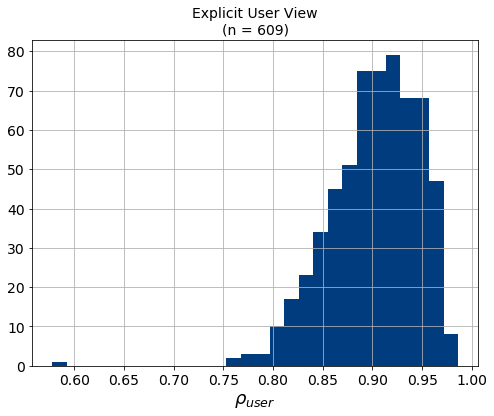

In [44]:
for idx, key in enumerate(list(results.keys())):
    plt.figure(figsize=(8,6))
    # plt.title("Ignore Sparse Zeros: {},\nUse Zero Mean: {},\nCorrelation Type: {}".format(
    #     key[0], key[1], key[2]))
    results[key].hist(bins='auto', color='#003C7E', alpha=1.0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(.04, 5,"$n={}$".format(results[key].notnull().sum()), fontsize=14)
    plt.title("Explicit User View\n(n = {})".format(results[key].notnull().sum()), fontsize=14)
    plt.xlabel(r'$\rho_{user}$', fontdict={'fontsize': 18})
    print(results[key].describe())
    print()
plt.show()

#### Item View
Skip items with only one rating

In [46]:
entity_type = 'item'
item_counts = np.array((data_sparse.todense() != 0).astype(int).sum(axis=0)).flatten()

corr_stats = []
for entity_id in range(entity_nums[entity_type]):
    if item_counts[entity_id] > 1:
        corr_stats.append(get_entity_corr_coef(data_sparse,
                                               entity_id,
                                               entity_type,
                                               embeddings,
                                               ignore_sparse_zeros=cov_config['ignore_sparse_zeros'],
                                               use_zero_mean=cov_config['use_zero_mean'],
                                               corr_type=cov_config['corr_type']))

corr_stats = pd.Series(corr_stats)
print("\nEntity Type:", entity_type)
print("Ignore Sparse Zeros:", cov_config['ignore_sparse_zeros'])
print("Use Zero Mean:", cov_config['use_zero_mean'])
print("Correlation Type:", cov_config['corr_type'])
print("---\nStats:\n---")
print(corr_stats.describe())
print()

results[(cov_config['ignore_sparse_zeros'],
         cov_config['use_zero_mean'],
         cov_config['corr_type'])] = corr_stats

item-44: Entity Embeddings are unlikely normally distributed
item-106: Covariances are unlikely normally distributed
item-212: Covariances are unlikely normally distributed
item-280: Entity Embeddings are unlikely normally distributed
item-283: Covariances are unlikely normally distributed
item-298: Covariances are unlikely normally distributed
item-319: Entity Embeddings are unlikely normally distributed
item-319: Covariances are unlikely normally distributed
item-367: Covariances are unlikely normally distributed
item-370: Covariances are unlikely normally distributed
item-388: Covariances are unlikely normally distributed
item-406: Covariances are unlikely normally distributed
item-412: Covariances are unlikely normally distributed
item-420: Covariances are unlikely normally distributed
item-443: Covariances are unlikely normally distributed
item-447: Covariances are unlikely normally distributed
item-449: Covariances are unlikely normally distributed
item-451: Covariances are unlik

item-1754: Covariances are unlikely normally distributed
item-1762: Covariances are unlikely normally distributed
item-1767: Entity Embeddings are unlikely normally distributed
item-1767: Covariances are unlikely normally distributed
item-1772: Covariances are unlikely normally distributed
item-1808: Covariances are unlikely normally distributed
item-1818: Entity Embeddings are unlikely normally distributed
item-1848: Covariances are unlikely normally distributed
item-1854: Covariances are unlikely normally distributed
item-1857: Covariances are unlikely normally distributed
item-1860: Entity Embeddings are unlikely normally distributed
item-1886: Covariances are unlikely normally distributed
item-1887: Covariances are unlikely normally distributed
item-1888: Entity Embeddings are unlikely normally distributed
item-1888: Covariances are unlikely normally distributed
item-1892: Covariances are unlikely normally distributed
item-1897: Entity Embeddings are unlikely normally distributed
i

item-2865: Covariances are unlikely normally distributed
item-2868: Entity Embeddings are unlikely normally distributed
item-2868: Covariances are unlikely normally distributed
item-2869: Covariances are unlikely normally distributed
item-2871: Covariances are unlikely normally distributed
item-2873: Covariances are unlikely normally distributed
item-2882: Covariances are unlikely normally distributed
item-2883: Covariances are unlikely normally distributed
item-2890: Covariances are unlikely normally distributed
item-2892: Covariances are unlikely normally distributed
item-2910: Covariances are unlikely normally distributed
item-2911: Covariances are unlikely normally distributed
item-2922: Covariances are unlikely normally distributed
item-2932: Entity Embeddings are unlikely normally distributed
item-2932: Covariances are unlikely normally distributed
item-2937: Covariances are unlikely normally distributed
item-2938: Covariances are unlikely normally distributed
item-2942: Covarian

item-3740: Covariances are unlikely normally distributed
item-3742: Covariances are unlikely normally distributed
item-3743: Covariances are unlikely normally distributed
item-3755: Covariances are unlikely normally distributed
item-3759: Covariances are unlikely normally distributed
item-3760: Covariances are unlikely normally distributed
item-3767: Covariances are unlikely normally distributed
item-3774: Covariances are unlikely normally distributed
item-3779: Covariances are unlikely normally distributed
item-3801: Covariances are unlikely normally distributed
item-3810: Covariances are unlikely normally distributed
item-3830: Covariances are unlikely normally distributed
item-3841: Covariances are unlikely normally distributed
item-3842: Covariances are unlikely normally distributed
item-3848: Covariances are unlikely normally distributed
item-3855: Covariances are unlikely normally distributed
item-3861: Covariances are unlikely normally distributed
item-3862: Covariances are unli

item-4558: Covariances are unlikely normally distributed
item-4560: Entity Embeddings are unlikely normally distributed
item-4560: Covariances are unlikely normally distributed
item-4564: Covariances are unlikely normally distributed
item-4573: Covariances are unlikely normally distributed
item-4574: Covariances are unlikely normally distributed
item-4582: Covariances are unlikely normally distributed
item-4588: Covariances are unlikely normally distributed
item-4599: Covariances are unlikely normally distributed
item-4602: Covariances are unlikely normally distributed
item-4606: Covariances are unlikely normally distributed
item-4618: Covariances are unlikely normally distributed
item-4644: Covariances are unlikely normally distributed
item-4663: Covariances are unlikely normally distributed
item-4665: Covariances are unlikely normally distributed
item-4669: Covariances are unlikely normally distributed
item-4675: Entity Embeddings are unlikely normally distributed
item-4675: Covarian

item-5194: Covariances are unlikely normally distributed
item-5197: Covariances are unlikely normally distributed
item-5200: Entity Embeddings are unlikely normally distributed
item-5200: Covariances are unlikely normally distributed
item-5201: Covariances are unlikely normally distributed
item-5202: Covariances are unlikely normally distributed
item-5203: Covariances are unlikely normally distributed
item-5204: Covariances are unlikely normally distributed
item-5207: Covariances are unlikely normally distributed
item-5209: Covariances are unlikely normally distributed
item-5210: Entity Embeddings are unlikely normally distributed
item-5210: Covariances are unlikely normally distributed
item-5212: Covariances are unlikely normally distributed
item-5213: Covariances are unlikely normally distributed
item-5214: Entity Embeddings are unlikely normally distributed
item-5214: Covariances are unlikely normally distributed
item-5215: Entity Embeddings are unlikely normally distributed
item-52

item-5630: Covariances are unlikely normally distributed
item-5633: Covariances are unlikely normally distributed
item-5634: Covariances are unlikely normally distributed
item-5638: Entity Embeddings are unlikely normally distributed
item-5638: Covariances are unlikely normally distributed
item-5646: Covariances are unlikely normally distributed
item-5647: Covariances are unlikely normally distributed
item-5653: Covariances are unlikely normally distributed
item-5657: Covariances are unlikely normally distributed
item-5660: Covariances are unlikely normally distributed
item-5662: Covariances are unlikely normally distributed
item-5670: Covariances are unlikely normally distributed
item-5673: Covariances are unlikely normally distributed
item-5675: Covariances are unlikely normally distributed
item-5683: Covariances are unlikely normally distributed
item-5685: Covariances are unlikely normally distributed
item-5686: Entity Embeddings are unlikely normally distributed
item-5686: Covarian

item-5975: Entity Embeddings are unlikely normally distributed
item-5975: Covariances are unlikely normally distributed
item-5976: Covariances are unlikely normally distributed
item-5979: Entity Embeddings are unlikely normally distributed
item-5979: Covariances are unlikely normally distributed
item-5993: Covariances are unlikely normally distributed
item-5996: Entity Embeddings are unlikely normally distributed
item-5996: Covariances are unlikely normally distributed
item-6000: Covariances are unlikely normally distributed
item-6002: Covariances are unlikely normally distributed
item-6006: Covariances are unlikely normally distributed
item-6014: Covariances are unlikely normally distributed
item-6021: Covariances are unlikely normally distributed
item-6022: Entity Embeddings are unlikely normally distributed
item-6022: Covariances are unlikely normally distributed
item-6023: Covariances are unlikely normally distributed
item-6033: Covariances are unlikely normally distributed
item-60

item-6343: Covariances are unlikely normally distributed
item-6345: Entity Embeddings are unlikely normally distributed
item-6345: Covariances are unlikely normally distributed
item-6349: Covariances are unlikely normally distributed
item-6350: Covariances are unlikely normally distributed
item-6351: Entity Embeddings are unlikely normally distributed
item-6351: Covariances are unlikely normally distributed
item-6353: Covariances are unlikely normally distributed
item-6354: Covariances are unlikely normally distributed
item-6358: Entity Embeddings are unlikely normally distributed
item-6367: Covariances are unlikely normally distributed
item-6369: Covariances are unlikely normally distributed
item-6370: Entity Embeddings are unlikely normally distributed
item-6370: Covariances are unlikely normally distributed
item-6371: Covariances are unlikely normally distributed
item-6376: Covariances are unlikely normally distributed
item-6377: Covariances are unlikely normally distributed
item-63

item-6711: Entity Embeddings are unlikely normally distributed
item-6711: Covariances are unlikely normally distributed
item-6713: Covariances are unlikely normally distributed
item-6717: Covariances are unlikely normally distributed
item-6720: Covariances are unlikely normally distributed
item-6721: Covariances are unlikely normally distributed
item-6728: Covariances are unlikely normally distributed
item-6734: Covariances are unlikely normally distributed
item-6738: Covariances are unlikely normally distributed
item-6744: Covariances are unlikely normally distributed
item-6750: Covariances are unlikely normally distributed
item-6763: Covariances are unlikely normally distributed
item-6768: Covariances are unlikely normally distributed
item-6776: Covariances are unlikely normally distributed
item-6779: Covariances are unlikely normally distributed
item-6781: Entity Embeddings are unlikely normally distributed
item-6781: Covariances are unlikely normally distributed
item-6785: Covarian

item-7219: Entity Embeddings are unlikely normally distributed
item-7219: Covariances are unlikely normally distributed
item-7223: Covariances are unlikely normally distributed
item-7224: Entity Embeddings are unlikely normally distributed
item-7224: Covariances are unlikely normally distributed
item-7228: Covariances are unlikely normally distributed
item-7229: Covariances are unlikely normally distributed
item-7230: Entity Embeddings are unlikely normally distributed
item-7230: Covariances are unlikely normally distributed
item-7231: Entity Embeddings are unlikely normally distributed
item-7231: Covariances are unlikely normally distributed
item-7232: Entity Embeddings are unlikely normally distributed
item-7232: Covariances are unlikely normally distributed
item-7233: Covariances are unlikely normally distributed
item-7237: Entity Embeddings are unlikely normally distributed
item-7237: Covariances are unlikely normally distributed
item-7238: Covariances are unlikely normally distrib

item-7580: Entity Embeddings are unlikely normally distributed
item-7580: Covariances are unlikely normally distributed
item-7581: Entity Embeddings are unlikely normally distributed
item-7581: Covariances are unlikely normally distributed
item-7586: Entity Embeddings are unlikely normally distributed
item-7586: Covariances are unlikely normally distributed
item-7591: Covariances are unlikely normally distributed
item-7596: Entity Embeddings are unlikely normally distributed
item-7596: Covariances are unlikely normally distributed
item-7599: Covariances are unlikely normally distributed
item-7604: Covariances are unlikely normally distributed
item-7605: Covariances are unlikely normally distributed
item-7612: Covariances are unlikely normally distributed
item-7623: Entity Embeddings are unlikely normally distributed
item-7623: Covariances are unlikely normally distributed
item-7627: Entity Embeddings are unlikely normally distributed
item-7627: Covariances are unlikely normally distrib

item-8388: Covariances are unlikely normally distributed
item-8397: Entity Embeddings are unlikely normally distributed
item-8397: Covariances are unlikely normally distributed
item-8413: Entity Embeddings are unlikely normally distributed
item-8413: Covariances are unlikely normally distributed
item-8423: Covariances are unlikely normally distributed
item-8437: Covariances are unlikely normally distributed
item-8443: Covariances are unlikely normally distributed
item-8445: Entity Embeddings are unlikely normally distributed
item-8445: Covariances are unlikely normally distributed
item-8450: Covariances are unlikely normally distributed
item-8484: Covariances are unlikely normally distributed
item-8496: Covariances are unlikely normally distributed
item-8503: Covariances are unlikely normally distributed
item-8505: Covariances are unlikely normally distributed
item-8528: Covariances are unlikely normally distributed
item-8529: Covariances are unlikely normally distributed
item-8541: Co

##### Visualize Results

count    4835.000000
mean        0.837591
std         0.079615
min         0.376488
25%         0.803581
50%         0.855494
75%         0.892415
max         0.971913
dtype: float64



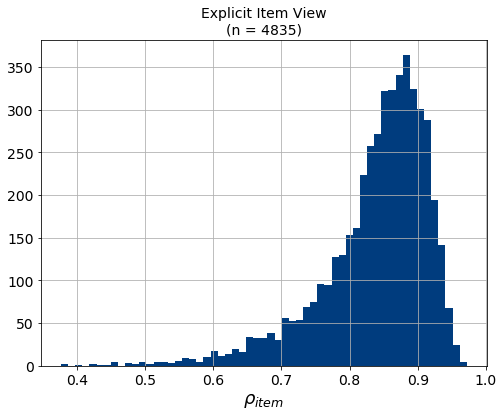

In [47]:
for idx, key in enumerate(list(results.keys())):
    # plt.subplot(4, 3, idx+1)
    plt.figure(figsize=(8,6))
    # plt.title("Ignore Sparse Zeros: {},\nUse Zero Mean: {},\nCorrelation Type: {}".format(
    #     key[0], key[1], key[2]))
    results[key].hist(bins='auto', color='#003C7E', alpha=1.0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(.20, 10,"$n={}$".format(results[key].notnull().sum()), fontsize=14)
    plt.title("Explicit Item View\n(n = {})".format(results[key].notnull().sum()), fontsize=14)
    plt.xlabel(r'$\rho_{item}$', fontdict={'fontsize': 18})
    print(results[key].describe())
    print()
plt.show()